## Data Preprocessing

#### Load required libraries

In [1]:
from __future__ import print_function
import json
import nltk
import os,sys
import codecs
import nltk
from nltk import word_tokenize
import re
import csv
import numpy as np

#### List all the corresponding paths for the pdtb datasets we have at hand 

In [2]:
train_relations_path = '/data/conll2016/en.train/relations.json'
train_parses_path = '/data/conll2016/en.train/parses.json'
dev_relations_path = '/data/conll2016/en.dev/relations.json'
dev_parses_path = '/data/conll2016/en.dev/parses.json'
train_conll_format_path = './data/conll2016/en.train/conll_format'
dev_conll_format_path = './data/conll2016/en.dev/conll_format'
train_raw_path = './data/conll2016/en.train/raw'
dev_raw_path = './data/conll2016/en.dev/raw'

#### Read the json files for training & development datasets (both relations and parses) and store them in varibles 

In [3]:
train_relations = [json.loads(s) for s in open(train_relations_path, 'r').readlines()]
train_parses = json.loads(open(train_parses_path).read()) 
dev_relations = [json.loads(s) for s in open(dev_relations_path, 'r').readlines()]
dev_parses = json.loads(open(dev_parses_path).read())

As an example, the training relations are in the following format:

In [18]:
dist_list = []
for relation in train_relations:
    if relation['Type'] == 'Explicit':
        arg1_last = relation['Arg1']['TokenList'][-1][2]
        arg1_first = relation['Arg1']['TokenList'][0][2]
        arg2_first = relation['Arg2']['TokenList'][0][2]
        arg2_last = relation['Arg2']['TokenList'][-1][2]
        connective = relation['Connective']['TokenList'][0][2]
        dist_list.append([(arg1_first, arg1_last), (arg2_first, arg2_last), connective])

print(dist_list[0:25])    

[[(145, 170), (173, 192), 172], [(215, 239), (241, 262), 243], [(284, 296), (287, 290), 286], [(0, 6), (8, 13), 7], [(0, 13), (16, 22), 15], [(37, 48), (51, 66), 50], [(122, 132), (135, 142), 134], [(180, 201), (204, 219), 203], [(221, 226), (229, 231), 228], [(289, 311), (314, 320), 313], [(313, 320), (323, 333), 322], [(335, 366), (382, 407), 368], [(368, 407), (372, 380), 370], [(368, 407), (410, 438), 409], [(520, 536), (539, 554), 540], [(539, 554), (571, 582), 573], [(571, 582), (598, 615), 599], [(409, 438), (618, 642), 625], [(652, 699), (703, 725), 706], [(727, 734), (737, 768), 736], [(782, 795), (798, 804), 797], [(797, 799), (801, 804), 800], [(806, 811), (814, 857), 813], [(893, 907), (909, 956), 910], [(991, 1005), (1008, 1022), 1007]]


In [60]:
d_list = []
for item in dist_list:
    if item[1][0] in range(item[0][0], item[0][1]+1) and item[1][1] in range(item[0][0], item[0][1]+1): # arg2 in arg1
        d_list.append(0)
    elif item[0][0] in range(item[1][0], item[1][1]+1) and item[0][1] in range(item[1][0], item[1][1]+1): # arg1 in arg2
        d_list.append(0)
    else: # arguments are separated
        if item[0][1] < item[1][0]: # arg1 comes before
            diff = (item[1][0] - item[0][1]) -1
            if item[2] in range(item[0][1]+1, item[1][0]):
                diff = max(0, diff-1)
        elif item[0][0] > item[1][1]: # arg2 comes before
            diff = (item[0][0] - item[1][1]) -1
            if item[2] in range(item[1][1]+1, item[0][0]):
                diff = max(0, diff-1)
        d_list.append(diff)
print(d_list)

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 14, 0, 1, 2, 16, 15, 179, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 23, 1, 0, 0, 18, 1, 1, 11, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 88, 1, 1, 0, 0, 1, 13, 0, 0, 0, 3, 58, 0, 1, 5, 0, 1, 2, 1, 1, 3, 4, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 0, 81, 1, 24, 0, 125, 1, 3, 54, 1, 26, 1, 8, 14, 10, 1, 0, 2, 1, 0, 1, 1, 0, 1, 4, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 97, 1, 128, 0, 0, 1, 1, 2, 1, 4, 0, 11, 0, 79, 2, 1, 40, 0, 0, 1, 0, 0, 148, 12, 0, 0, 4, 0, 0, 0, 2, 1, 0, 0, 11, 0, 0, 0, 1, 0, 0, 4, 1, 0, 12, 0, 0, 2, 5, 0, 6, 6, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 24, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 11, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 1, 0, 0, 0, 2, 2, 1, 3, 2, 1, 1, 4, 4, 2, 1, 1, 21, 1, 1, 53, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 5, 0, 37, 0, 1, 1, 33, 1, 1, 1, 0, 1, 1, 1, 6, 1, 0, 0, 2, 75, 0, 1, 1, 0, 1, 1, 71, 80, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 160, 2, 35, 0, 17, 1, 1, 0, 2, 2, 1, 0, 3, 7, 0, 4, 18, 1, 3

In [61]:
d_list_adjusted = []
for item in d_list:
    if item == 0:
        d_list_adjusted.append("0")
    elif item == 1:
        d_list_adjusted.append("1")
    elif item == 2:
        d_list_adjusted.append("2")
    elif 3 <= item and item >=10:
        d_list_adjusted.append("3-10")
    else:
        d_list_adjusted.append(">10")

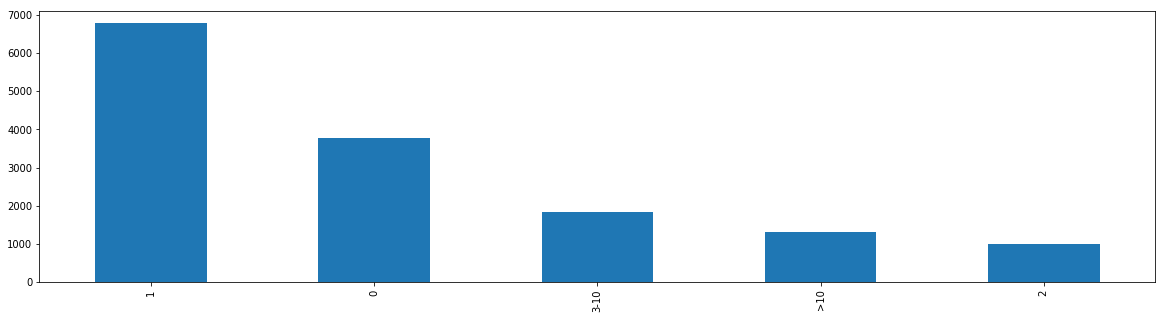

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(d_list_adjusted).value_counts().sort_values(ascending = False).plot('bar', figsize=(20, 5))
plt.show()

In [65]:
perc0 = d_list_adjusted.count("0")/len(d_list_adjusted)
perc1 = d_list_adjusted.count("1")/len(d_list_adjusted)
perc2 = d_list_adjusted.count("2")/len(d_list_adjusted)
perc3_10 = d_list_adjusted.count("3-10")/len(d_list_adjusted)
perc10 = d_list_adjusted.count(">10")/len(d_list_adjusted)

In [66]:
print(perc0, perc1, perc2, perc3_10, perc10)

0.2572340714576824 0.4599918489335688 0.06887651134356745 0.12498301861160169 0.08891454965357967


In [4]:
train_relations[96]

{'Arg1': {'CharacterSpanList': [[1193, 1237]],
  'RawText': 'They sow a row of male-fertile plants nearby',
  'TokenList': [[1193, 1197, 219, 9, 0],
   [1198, 1201, 220, 9, 1],
   [1202, 1203, 221, 9, 2],
   [1204, 1207, 222, 9, 3],
   [1208, 1210, 223, 9, 4],
   [1211, 1223, 224, 9, 5],
   [1224, 1230, 225, 9, 6],
   [1231, 1237, 226, 9, 7]]},
 'Arg2': {'CharacterSpanList': [[1239, 1244], [1250, 1283]],
  'RawText': 'which pollinate the male-sterile plants',
  'TokenList': [[1239, 1244, 228, 9, 9],
   [1250, 1259, 230, 9, 11],
   [1260, 1263, 231, 9, 12],
   [1264, 1276, 232, 9, 13],
   [1277, 1283, 233, 9, 14]]},
 'Connective': {'CharacterSpanList': [[1245, 1249]],
  'RawText': 'then',
  'TokenList': [[1245, 1249, 229, 9, 10]]},
 'DocID': 'wsj_0209',
 'ID': 3269,
 'Sense': ['Temporal.Asynchronous.Precedence'],
 'Type': 'Explicit'}

#### Basically the relations consist of the following information: <br>
The document id ('DocID') <br>
The sentence id ('ID')<br>
The sense of the connective ('Sense')<br>
The type of the relation ('Type')<br>
For both **arg1** and **arg2**, and the **connective**: <br>
- The indices of the first and last character of the whole raw text within that document ('CharacterSpanList')
- The raw text ('RawText')
- A list of lists, where each sublist consists of the following five elements _for each token_ in the sentence  ('TokenList'):
> - The first character index within the document
> - The last character index within the document
> - The index of the token within the document (0 is the very first token in that very document)
> - The index of the sentence within the document
> - The index of the token within the sentence

Remember that for the **connective**, there is no information when the type of the relation is **non-explicit**. <br>


#### From this information, using the following function, we extract certain required portions to form a summary of relations

In [5]:
def generate_dataset_token(pdtb):
    outlist=[]
    #add_connective_heads(pdtb)
    doc_before = ""
    
    count_total = 0 
    count_arg_1=0
    for relation in filter(lambda i: i['Type'] == 'Explicit', pdtb):
        
        doc_id = relation['DocID']
        if doc_before != doc_id:
            count=0
                
        # get the sentence indices for arg1 & arg2 & conn
        arg1_sentences = set([sent_ind 
                                for char_start,char_end,token_ind, 
                                    sent_ind, token_ind_sent 
                                in relation['Arg1']['TokenList']])        
        arg2_sentences = set([sent_ind 
                                for char_start,char_end,token_ind, 
                                    sent_ind, token_ind_sent 
                                in relation['Arg2']['TokenList']])
        conn_sentences = set([sent_ind 
                                for char_start,char_end,token_ind, 
                                    sent_ind, token_ind_sent 
                                in relation['Connective']['TokenList']])
        
        arg_set = arg1_sentences.union(arg2_sentences) # comb of arg1 and arg2
        cond_connective_in_same_set = len(conn_sentences&arg_set) != len(conn_sentences)
        

        Arg1_list = [[sent_ind, token_ind_sent] for char_start,char_end,token_ind, sent_ind, token_ind_sent 
                 in relation['Arg1']['TokenList']]
        Arg2_list = [[sent_ind, token_ind_sent] for char_start,char_end,token_ind, sent_ind, token_ind_sent 
                 in relation['Arg2']['TokenList']]
        con_list = relation['Connective']['TokenList'][0][3:5]
        
        sent_list = list(set(list(arg1_sentences)+list(arg2_sentences)+list(conn_sentences))) # list of sent indices
                                                                                              # that include everything
        maxim, minim = max(sent_list), min(sent_list)
        total_range = list(range(minim,maxim+1)) # now includes also the sentences that lie in between
        
        outlist.append([doc_id,count,Arg1_list,Arg2_list,con_list,total_range])
        
        count=count+1       
        count_arg_1 += 1        
        count_total += 1
        doc_before = doc_id
    
    print("A total of", count_total, "relations are processed &" , count_arg_1, "arg_1's are found")      
        
    return outlist


In [6]:
generate_dataset_token(dev_relations)[0:1]

A total of 680 relations are processed & 680 arg_1's are found


[['wsj_2200',
  0,
  [[2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10]],
  [[2, 13], [2, 14], [2, 15], [2, 16], [2, 17], [2, 18]],
  [2, 12],
  [2]]]

In [7]:
train_spans = generate_dataset_token(train_relations)
dev_spans = generate_dataset_token(dev_relations)

A total of 14722 relations are processed & 14722 arg_1's are found
A total of 680 relations are processed & 680 arg_1's are found


#### So the format that we have at hand right now is like this: <br>
A list of lists, where each sublist corresponds to an **explicit** relation and includes:
- Doc_ID that this relation belongs to
- Number of the relation that is processed within this Doc
- A list of lists where each sublist includes the sentence id and the token id in that sentence, for arg1
- Same for arg2
- Same for the connective
- The list of sentence indices that contain the whole relation: (e.g. if arg1 and conn is in the first sentence, and arg2 is in the third sentence, than this list will be [1,2,3]

#### Now we have an exhaustive list of all the explicit relations with their corresponding Doc_IDs. We know which sentences correspond to arguments, also which tokens in those sentences are really the part of the argument, and if the arguments are far apart, what are the sentences lying in between. If we could get the token of all documents in an ordered list, it would be possible to use the output of the previous function to actually tag all the tokens within a relation as arg1, arg2, conn or none:

In [8]:
def readPathToken(path):
    dictWords= {}
    dictPOS  = {}
    dictIndex = {}
    files = os.listdir(path) #returns a list containing the names of the entries in the directory given by path
    final_list = []
    for name in files: # each name will be in this example format: wsj_2216.conll
        full_path = os.path.join(path, name) # we get something like:'./data/conll2016/en.dev/conll_format/wsj_2216.conll'
        sentence_list = []
        pos_list = []
        index_list = []
        with codecs.open(full_path,'r',encoding='utf-8',errors='ignore') as fdata:
            filedata = fdata.read()
        
        span_list  = filedata.split('\n\n') # spanlists will have a format like: 
                        # ['0\t0\t0\tBancOklahoma\tNNP\t_\t_\t_\n1\t0\t1\tCorp.\tNNP\t_\t_\t_\n2\t0\t2\tsaid\tVBD\t_\.......]
        for span in span_list[:-1]: # don't take the very last element, because it is ''
            wordList=[]
            posList =[]
            indexList = []
            
            #split with new line
            span_lines = span.split('\n')
            for word_tab in span_lines:
                words = word_tab.split('\t') # so after some processing, the format of the words will be like:
                                             # ['0', '0', '0', 'BancOklahoma', 'NNP', '_', '_', '_']
                try:
                    wordList.append(words[3]) # so the 4th item includes the token itself
                    posList.append(words[4]) # and the 5th item is its POS
                    indexList.append(words[0]) # the first item is its index in the document
                except:
                    print("error at : ", full_path)
                    
            sentence_list.append(wordList) # for each span in the span list, we collect the words and the store them in a list
            pos_list.append(posList) # the same is valid for the POS tags
            index_list.append(indexList)
            
        name = name[:-6] # remove the '.conll' part of the name   
        dictWords[name] = sentence_list
        dictPOS[name] = pos_list
        dictIndex[name] = index_list
    return [dictWords , dictPOS, dictIndex]

#### The previous function returns two dictionaries that are keyed by Doc_ID's, and valued by a list of lists where each sublist includes either the tokens of ordered sentences in that Doc, or the POS tags. After recording these dictionaries for the training and development sets, an example is given:

In [9]:
train_words, train_POS, train_index = readPathToken(train_conll_format_path)
dev_words, dev_POS, dev_index = readPathToken(dev_conll_format_path)

In [10]:
dev_words

{'wsj_2200': [['Influential',
   'members',
   'of',
   'the',
   'House',
   'Ways',
   'and',
   'Means',
   'Committee',
   'introduced',
   'legislation',
   'that',
   'would',
   'restrict',
   'how',
   'the',
   'new',
   'savings-and-loan',
   'bailout',
   'agency',
   'can',
   'raise',
   'capital',
   ',',
   'creating',
   'another',
   'potential',
   'obstacle',
   'to',
   'the',
   'government',
   "'s",
   'sale',
   'of',
   'sick',
   'thrifts',
   '.'],
  ['The',
   'bill',
   ',',
   'whose',
   'backers',
   'include',
   'Chairman',
   'Dan',
   'Rostenkowski',
   '-LRB-',
   'D.',
   ',',
   'Ill.',
   '-RRB-',
   ',',
   'would',
   'prevent',
   'the',
   'Resolution',
   'Trust',
   'Corp.',
   'from',
   'raising',
   'temporary',
   'working',
   'capital',
   'by',
   'having',
   'an',
   'RTC-owned',
   'bank',
   'or',
   'thrift',
   'issue',
   'debt',
   'that',
   'would',
   "n't",
   'be',
   'counted',
   'on',
   'the',
   'federal',
   'budge

In [11]:
dev_index

{'wsj_2200': [['0',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '16',
   '17',
   '18',
   '19',
   '20',
   '21',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '30',
   '31',
   '32',
   '33',
   '34',
   '35',
   '36'],
  ['37',
   '38',
   '39',
   '40',
   '41',
   '42',
   '43',
   '44',
   '45',
   '46',
   '47',
   '48',
   '49',
   '50',
   '51',
   '52',
   '53',
   '54',
   '55',
   '56',
   '57',
   '58',
   '59',
   '60',
   '61',
   '62',
   '63',
   '64',
   '65',
   '66',
   '67',
   '68',
   '69',
   '70',
   '71',
   '72',
   '73',
   '74',
   '75',
   '76',
   '77',
   '78',
   '79',
   '80',
   '81'],
  ['82',
   '83',
   '84',
   '85',
   '86',
   '87',
   '88',
   '89',
   '90',
   '91',
   '92',
   '93',
   '94',
   '95',
   '96',
   '97',
   '98',
   '99',
   '100',
   '101'],
  ['102',
   '103',
   '104',
   '105',
   '106',
   '107',
   '108',
   '1

#### It is time to merge these functions and create a final output csv file that holds every information that we seek:

First a handler function for writing csv's.

In [12]:
def writeCSV(filename, outlist):    
    myFile = open(filename, 'w', newline='')
    with myFile:
        writer = csv.writer(myFile)
        writer.writerows(outlist)
    print("Writing complete")

Then the main function for merging information is as follows:

In [13]:
def makeCSV(output_csv_filename, span, dict_sent, dict_POS):
    
    finalList = []
    for doc_Id, span_Id, arg1, arg2, connector, combined in span:
        words_comb = {}
        pos_comb = {}
        span_list = {}
        span_total_list = []
        for sentence_number in combined:
            words_comb[sentence_number]  = dict_sent[doc_Id][sentence_number] # retrieves the words of the nth sentence from that doc
            pos_comb[sentence_number]  = dict_POS[doc_Id][sentence_number]  # the same for POS tags
            #make data structure for holding values
            span_list[sentence_number] = [[doc_Id, span_Id, word, pos, ""] \
                                          for word, pos in zip(words_comb[sentence_number],pos_comb[sentence_number])] 

        #arg1
        for sentID, tokenID in arg1:
            span_list[sentID][tokenID][4]= 'arg1'
        #arg2
        for sentID, tokenID in arg2:
            span_list[sentID][tokenID][4]= 'arg2'
        #connective
        a_np = np.array(connector)
        if len(a_np.shape)>1:
            for sentID, tokenID in connector:
                span_list[sentID][tokenID][4]= 'connective'
        else:
            span_list[connector[0]][connector[1]][4]= 'connective'   
        #none for rest
        for key, valList in span_list.items():
            for count in range(0,len(valList)):
                val = span_list[key][count][4]
                if val == '':
                    span_list[key][count][4]='none'

        #Making span total list
        for key, valList in span_list.items():
            span_total_list = span_total_list+valList
        #final list
        finalList= finalList+span_total_list

    writeCSV(output_csv_filename, finalList)


In [14]:
makeCSV("dev_token_all.csv", dev_spans ,dev_words, dev_POS)
makeCSV("train_token_all.csv", train_spans ,train_words, train_POS)

Writing complete
Writing complete


#### For the <font color=red>test data</font>, we need to apply a similar procedure. However there are small changes, which are defined below in the markdown cells and as comment lines:


Given a random raw text without any features defined, the model should be able to parse the text into logical subunits which hopefully comprise a complete discourse relation. Since the neural network model will be trained on pre-annotated and distilled relational subunits, it is unlikely that it will be successful in terms of processing much larger text units containing non-relational components. Therefore we need a starting point, by which the raw test text units can be transformed into processable inputs insofar as the network is accustomed to. Our current methodology consists of three consecutive tasks:
- use the lin parser to spot potential connective candidates in a text
- use certain windows to collect the neighbouring k previous and l next sentences of the connective
- mark all such text spans as a relation, and combine all to form a test input

We apply the parser script on the test set texts, with varying epochs. The resulting output file, which can be exemplified with the file '500_epochs_test.json', contains relations and a lot of information about such relations in the following example format:

{<br>"Arg1": <br>
{"TokenList":[[171,174,32,1,0],[175,179,33,1,1],[180,182,34,1,2],[183,186,35,1,3],[187,191,36,1,4],[192,194,37,1,5],[194,197,38,1,6],[198,203,39,1,7]],<br>"RawText":"The size of the cuts is n't known"},<br><br>"Arg2":<br>{"TokenList":[[209,213,42,1,10],[213,216,43,1,11],[217,219,44,1,12],[220,228,45,1,13],[229,231,46,1,14],[232,235,47,1,15],[236,247,48,1,16],[248,251,49,1,17],[252,262,50,1,18],[263,271,51,1,19],[271,272,52,1,20],[273,278,53,1,21],[279,281,54,1,22],[282,293,55,1,23],[294,297,56,1,24],[298,306,57,1,25],[307,310,58,1,26],[311,319,59,1,27],[319,320,60,1,28],[321,329,61,1,29],[330,335,62,1,30],[336,339,63,1,31],[340,347,64,1,32],[348,353,65,1,33],[354,357,66,1,34],[358,361,67,1,35],[362,369,68,1,36],[370,373,69,1,37]],<br>"RawText":"they 'll be centered in the exploration and production division , which is responsible for locating oil reserves , drilling wells and pumping crude oil and natural gas"},<br><br>"Connective":{"TokenList":[[205,208,41,1,9]],<br>"RawText":"but"},<br><br>"DocID":"wsj_1148",<br>"Sense":["Comparison.Contrast"],<br>"Type":"Explicit",<br>"ArgPos":"SS",<br>"Confidences":{"Sense":0.6048815317,"Arg1":0.8698600369,"ArgPos":0.9904402099,"Arg2":0.9261875246,"Connective":0.9991256966},<br>"Confidence":0.8780989999<br>}

Now we need a function to retrieve the necessary information from such relations. Mostly what interests us is the **connective**, the sentence index of connectives within a document, connective token index in the sentence and the index of the sentence in the document, and newly generated text span based on our window rules

In [178]:
def test_connectives(pdtb, sent_before, sent_after): # takes the relations that are stored in the parser output file
                                                # also it takes the number of sentences we'd like include in a test 
                                                # span before and after the sentence containing the connective
    outlist = []
    #add_connective_heads(pdtb)
    doc_before = ""    
    count_total = 0 
    count_arg_1 = 0
    
    for relation in filter(lambda i: i['Type'] == 'Explicit', pdtb): # filter out the non-explicit relations
        
        doc_id = relation['DocID']
        if doc_before != doc_id:
            count=0
                
        # get the sentence indices for conn
        conn_sentences = list(set([sent_ind 
                                for char_start,char_end,token_ind, 
                                    sent_ind, token_ind_sent 
                                in relation['Connective']['TokenList']]))
        
        # specify the window size
        if conn_sentences[0] - sent_before < 0: # if n sentences before the connective goes below 0, we need to restrict it with 0
            arg_first = 0
            arg_last = conn_sentences[0] + sent_after
            arg_span = list(range(arg_first, arg_last + 1))
        else:
            arg_first = conn_sentences[0] - sent_before
            arg_last = conn_sentences[0] + sent_after
            arg_span = list(range(arg_first, arg_last + 1))

        con_list = relation['Connective']['TokenList'][0][3:5] # [sent index in the doc, connective token index in the sent]
        
        outlist.append([doc_id, count, arg_first, arg_last, con_list, arg_span])
        
        count = count + 1       
        count_arg_1 += 1        
        count_total += 1
        doc_before = doc_id
    
    print("A total of", count_total, "relations are processed &" , count_arg_1, "arg_1's are found")      
        
    return outlist

In [179]:
test_spans = test_connectives([json.loads(s) for s in open('500_epochs_test.json', 'r').readlines()], 1, 0)

A total of 996 relations are processed & 996 arg_1's are found


We'll use the same readPathToken function to transform the raw test dataset that is in the conll format to a bunch of lists containing the word and POS lists of all the relations grouped by document ID.

In [180]:
test_words, test_POS, test_index = readPathToken('./data/conll2016/en.test/conll_format')

In [181]:
print(test_words['wsj_2300'][0:2])
print(test_POS['wsj_2300'][0:2])
print(test_index['wsj_2300'][0:2])

[['No', ',', 'it', 'was', "n't", 'Black', 'Monday', '.'], ['But', 'while', 'the', 'New', 'York', 'Stock', 'Exchange', 'did', "n't", 'fall', 'apart', 'Friday', 'as', 'the', 'Dow', 'Jones', 'Industrial', 'Average', 'plunged', '190.58', 'points', '--', 'most', 'of', 'it', 'in', 'the', 'final', 'hour', '--', 'it', 'barely', 'managed', 'to', 'stay', 'this', 'side', 'of', 'chaos', '.']]
[['UH', ',', 'PRP', 'VBD', 'RB', 'NNP', 'NNP', '.'], ['CC', 'IN', 'DT', 'NNP', 'NNP', 'NNP', 'NNP', 'VBD', 'RB', 'VB', 'RB', 'NNP', 'IN', 'DT', 'NNP', 'NNP', 'NNP', 'NNP', 'VBD', 'CD', 'NNS', ':', 'JJS', 'IN', 'PRP', 'IN', 'DT', 'JJ', 'NN', ':', 'PRP', 'RB', 'VBD', 'TO', 'VB', 'DT', 'NN', 'IN', 'NN', '.']]
[['0', '1', '2', '3', '4', '5', '6', '7'], ['8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47']]


Finally we transform the datasets we obtained into a csv file, as it has been done for the training and the test datasets

However a slightly different function will be used to store also the indices of tokens (not in the csv file but in a separate list). The reason for that is related to the desired output format of the conll evaluator. The desired format example is given as follows:

{'Arg1': {'TokenList': [275,276,277,278,...]}, <br>
 'Arg2': {'TokenList': [329,330,331,332,333,334,335,...]}, <br>
 'Connective': {'TokenList': []},<br>
 'DocID': 'wsj_1000',<br>
 'Sense': ['Expansion.Conjunction'],<br>
 'Type': 'Implicit'}<br>

In the following function, we used duplicates of certain placeholder lists and dictionaries, one copy for the csv output, and one copy for the list variable output (that includes the index values as well). The variable names that are related to the desired conll evaluator output format contain 'out' or 'output':

In [182]:
def makeCSV_test(output_csv_filename, span, words, POS, indices):
    
    finalList = []
    final_out_list = [] # same placeholder, but will include also the indices of tokens
    
    for doc_Id, span_Id, arg1, arg2, connector, combined in span: 
        words_comb = {}
        pos_comb = {}
        indices_comb = {} # dictionary of indices
        
        span_list = {}
        output_span_list = {}
        
        span_total_list = []
        span_out_total_list = []
        # we have to make sure that the relation sentence span is within the bounds of the document
        # if not, we need to limit the span with the final sentence index of the document
        first_sent_index = combined[0]
        for sentence_number in combined:            
            if sentence_number >= len(words[doc_Id]):
                combined = list(range(first_sent_index, len(words[doc_Id])))
                
        for sentence_number in combined: # for all the sentences in the relation span
            words_comb[sentence_number]  = words[doc_Id][sentence_number] # retrieves the words of the nth sentence from that doc
            pos_comb[sentence_number]  = POS[doc_Id][sentence_number]  # the same for POS tags
            #make data structure for holding values
            span_list[sentence_number] = [[doc_Id, span_Id, word, pos, "none"] \
                                          for word, pos in zip(words_comb[sentence_number],pos_comb[sentence_number])]   

            indices_comb[sentence_number] = indices[doc_Id][sentence_number]  # the same for sentence indices
            output_span_list[sentence_number] = [[doc_Id, span_Id, word, pos, "none", index] \
                                          for word, pos, index in zip(words_comb[sentence_number],\
                                                                        pos_comb[sentence_number], indices_comb[sentence_number])]
            
        #Making span total list
        for key, valList in span_list.items():
            span_total_list = span_total_list + valList
        for key, valList in output_span_list.items():
            span_out_total_list = span_out_total_list + valList
        #final lists
        finalList = finalList + span_total_list
        final_out_list = final_out_list + span_out_total_list

    writeCSV(output_csv_filename, finalList)
    return final_out_list


In [183]:
#record the data also to a variable that will later be used to store additional information
test_data = makeCSV_test("test_token_all.csv", test_spans ,test_words, test_POS, test_index )

Writing complete


'test_data' list contains the same information as the csv file, but additionally it has the token indices as the last item in each sublist.

In [184]:
test_data

[['wsj_2325', 0, 'Major', 'JJ', 'none', '15'],
 ['wsj_2325', 0, 'oil', 'NN', 'none', '16'],
 ['wsj_2325', 0, 'companies', 'NNS', 'none', '17'],
 ['wsj_2325', 0, 'in', 'IN', 'none', '18'],
 ['wsj_2325', 0, 'the', 'DT', 'none', '19'],
 ['wsj_2325', 0, 'next', 'JJ', 'none', '20'],
 ['wsj_2325', 0, 'few', 'JJ', 'none', '21'],
 ['wsj_2325', 0, 'days', 'NNS', 'none', '22'],
 ['wsj_2325', 0, 'are', 'VBP', 'none', '23'],
 ['wsj_2325', 0, 'expected', 'VBN', 'none', '24'],
 ['wsj_2325', 0, 'to', 'TO', 'none', '25'],
 ['wsj_2325', 0, 'report', 'VB', 'none', '26'],
 ['wsj_2325', 0, 'much', 'RB', 'none', '27'],
 ['wsj_2325', 0, 'less', 'JJR', 'none', '28'],
 ['wsj_2325', 0, 'robust', 'JJ', 'none', '29'],
 ['wsj_2325', 0, 'earnings', 'NNS', 'none', '30'],
 ['wsj_2325', 0, 'than', 'IN', 'none', '31'],
 ['wsj_2325', 0, 'they', 'PRP', 'none', '32'],
 ['wsj_2325', 0, 'did', 'VBD', 'none', '33'],
 ['wsj_2325', 0, 'for', 'IN', 'none', '34'],
 ['wsj_2325', 0, 'the', 'DT', 'none', '35'],
 ['wsj_2325', 0, 't

Test that there are the same number of relations in the csv file as the ones in the parser output:

In [132]:
import pandas as pd 
data = pd.read_csv("test_token_all.csv", header=None) 
doc_list = data[0].unique()
count = 0
for doc in doc_list:
    sub_data = data[data[0]==str(doc)]
    relation_counts = sub_data[1].unique()
    max_count = max(relation_counts) + 1
    count += max_count
print("There are", count, "relations recorded in the csv file!")

There are 996 relations recorded in the csv file!


--------
--------
Analysis for the window size - **this part will be used later on in the window size experiments!!!** -

#### A example training relations is recorded in the following format:
['wsj_0207', 5, [[7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5]], [[7, 8], [7, 9], [7, 10]], [7, 7], [7]]] <br>
-> <br>
[Doc ID, Arg1 sentences with token indices, Arg2 sentences with token indices, Connective, The sentence index span of the whole relation]

In [29]:
conn_to_arg1 = [] # a list for storing the distance from the sentence containing the connective, to the sentence containing arg1
conn_to_arg2 = [] # the same for arg2
for span in train_spans:
    connective = span[4][0] #sentence index of the connective in a given relation span
    arg1 = span[2] # arg1 info
    arg2 = span[3] # arg2 info
    arg1_sent_list = []
    arg2_sent_list = []
    for token in arg1:
        arg1_sent_list.append(token[0]) # store the sentence indices of arg1s in a list
    arg1_list = list(set(arg1_sent_list)) # remove duplicates from that list
    arg1_min = min(arg1_list) # find the minimum sentence index
    arg1_max = max(arg1_list) # and the max
    
    for token in arg2: # same procedure for arg2 again
        arg2_sent_list.append(token[0])
    arg2_list = list(set(arg2_sent_list))
    arg2_min = min(arg2_list)
    arg2_max = max(arg2_list)
    
    # now find the greatest distance from the connective, to arg1 and arg2 respectively. 
    # this procedure assumes that most of the time arg1 will come before the connective, and arg2 after the connective
    conn_to_arg1.append(max(connective - arg1_min, connective - arg1_max)) 
    conn_to_arg2.append(max(arg2_min - connective, arg2_max - connective))

        
print("On average, the arg1 comes", sum(conn_to_arg1)/len(train_spans), \
      "sentences before the sentence that contains the connective")
print("On average, the arg2 comes", sum(conn_to_arg2)/len(train_spans), \
      "sentences before the sentence that contains the connective")
 


On average, the arg1 comes 0.7592718380654803 sentences before the sentence that contains the connective
On average, the arg2 comes 0.01032468414617579 sentences before the sentence that contains the connective


--------
-------
--------

# Neural Network Implementation

Import necessary packages

In [30]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


#### We need to find all the unique words in the whole dataset (training and development combined) to create word embeddings:

In [31]:
# read the csv files generated
data_train = pd.read_csv("csv_files/train_token_all.csv",header=None)
data_dev   = pd.read_csv("csv_files/dev_token_all.csv" ,header=None)
# add column names
data_train.columns=['file','spanNo','word','pos','tag']
data_dev.columns=['file','spanNo','word','pos','tag']
# add another column of lowercased tokens
data_train['lower_word'] = data_train['word'].str.lower()
data_dev['lower_word']   = data_dev['word'].str.lower()
# and combine them 
data_combined = data_train.append(data_dev)

The combined data should look like:

In [32]:
data_combined[0:10]

file  spanNo        word  pos   tag  lower_word
0  wsj_0204       0         The   DT  arg1         the
1  wsj_0204       0         new   JJ  arg1         new
2  wsj_0204       0          ``   ``  arg1          ``
3  wsj_0204       0      social   JJ  arg1      social
4  wsj_0204       0      choice   NN  arg1      choice
5  wsj_0204       0          ''   ''  arg1          ''
6  wsj_0204       0        fund   NN  arg1        fund
7  wsj_0204       0        will   MD  arg1        will
8  wsj_0204       0        shun   VB  arg1        shun
9  wsj_0204       0  securities  NNS  arg1  securities

In [33]:
# get the uniqe words and add 'endpad' for padding operation
unique_words = list(set(data_combined["lower_word"].values))
unique_words.append("endpad")
# count the number of unique words
unique_word_count = len(unique_words)
print("Number of total unique words:", unique_word_count)

Number of total unique words: 28264


Do the same for the relation tags and the POS tags respectively

In [34]:
unique_tags = list(set(data_combined["tag"].values))
unique_tags.append("endpad")
unique_tag_count = len(unique_tags)
print("Number of total unique tags:", unique_tag_count)

Number of total unique tags: 5


In [35]:
unique_POS = list(set(data_combined["pos"].values))
unique_POS.append("endpad")
unique_POS_count = len(unique_POS)
print("Number of total unique POS tags:", unique_POS_count)

Number of total unique POS tags: 46


#### We use pickle to record the variables we generated. They will be used later in network training

In [36]:
def writePickle( Variable, fname):
    filename = fname +".pkl"
    f = open("pickle_vars/"+filename, 'wb')
    pickle.dump(Variable, f)
    f.close()
def readPickle(fname):
    filename = "pickle_vars/"+fname +".pkl"
    f = open(filename, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

In [37]:
writePickle(unique_words,"unique_words_training_dev")
writePickle(unique_tags,"unique_tags_training_dev")
writePickle(unique_POS,"unique_POS_training_dev")

#### We create a class to extact the sentences formed by words present in the data files:

In [38]:
class SentenceGetter_m(object):    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,p, t) for w, p, t in zip(s["lower_word"].values.tolist(),
                                                     s["pos"].values.tolist(),
                                                     s["tag"].values.tolist())]
        self.grouped = self.data.groupby(["file","spanNo"]).apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [39]:
# for training dataset
sentences_train = SentenceGetter_m(data_train).sentences
# for development dataset
sentences_dev = SentenceGetter_m(data_dev).sentences
# for the combined dataset
sentences_combined = SentenceGetter_m(data_combined).sentences


The combined dataset will yield sentences in the following format

In [40]:
sentences_combined[0]

[('the', 'DT', 'arg1'),
 ('new', 'JJ', 'arg1'),
 ('``', '``', 'arg1'),
 ('social', 'JJ', 'arg1'),
 ('choice', 'NN', 'arg1'),
 ("''", "''", 'arg1'),
 ('fund', 'NN', 'arg1'),
 ('will', 'MD', 'arg1'),
 ('shun', 'VB', 'arg1'),
 ('securities', 'NNS', 'arg1'),
 ('of', 'IN', 'arg1'),
 ('companies', 'NNS', 'arg1'),
 ('linked', 'VBN', 'arg1'),
 ('to', 'TO', 'arg1'),
 ('south', 'NNP', 'arg1'),
 ('africa', 'NNP', 'arg1'),
 (',', ',', 'arg1'),
 ('nuclear', 'JJ', 'arg1'),
 ('power', 'NN', 'arg1'),
 ('and', 'CC', 'arg1'),
 ('in', 'IN', 'arg1'),
 ('some', 'DT', 'arg1'),
 ('cases', 'NNS', 'arg1'),
 (',', ',', 'arg1'),
 ('northern', 'NNP', 'arg1'),
 ('ireland', 'NNP', 'arg1'),
 ('.', '.', 'none'),
 ('also', 'RB', 'connector'),
 ('excluded', 'VBN', 'arg2'),
 ('will', 'MD', 'arg2'),
 ('be', 'VB', 'arg2'),
 ('investments', 'NNS', 'arg2'),
 ('in', 'IN', 'arg2'),
 ('companies', 'NNS', 'arg2'),
 ('with', 'IN', 'arg2'),
 ('``', '``', 'arg2'),
 ('significant', 'JJ', 'arg2'),
 ("''", "''", 'arg2'),
 ('business'

With the following loop, we only extract the words

In [41]:
sentence_list = []
for sentence in sentences_combined:
    words =[]
    for word, pos, arg in sentence:
        words.append(word)
    sentence_list.append(words)
sentence_list[0].append('endpad') # we don't forget add 'endpad' to at least one sentence in the list
print(sentence_list[0:1])

[['the', 'new', '``', 'social', 'choice', "''", 'fund', 'will', 'shun', 'securities', 'of', 'companies', 'linked', 'to', 'south', 'africa', ',', 'nuclear', 'power', 'and', 'in', 'some', 'cases', ',', 'northern', 'ireland', '.', 'also', 'excluded', 'will', 'be', 'investments', 'in', 'companies', 'with', '``', 'significant', "''", 'business', 'stemming', 'from', 'weapons', 'manufacture', ',', 'alcoholic', 'beverages', 'or', 'tobacco', '.', 'endpad']]


Record the max and min length of the datasets, to be used for padding later

In [42]:
max_len_train = max([len(s) for s in sentences_train])
min_len_train = min([len(s) for s in sentences_train])
max_len_dev = max([len(s) for s in sentences_dev])
min_len_dev = min([len(s) for s in sentences_dev])
print("The training set has a sentence length range of", (max_len_train, min_len_train))
print("The development set has a sentence length range of", (max_len_dev, min_len_dev))

The training set has a sentence length range of (1169, 7)
The development set has a sentence length range of (1146, 8)


#### For working with the neural network structure, we need to generate dictionaries that map words and tags and POS tags to indices, and vice versa:

In [43]:
word2idx = {w: i for i, w in enumerate(unique_words)}
tag2idx = {t: i for i, t in enumerate(unique_tags)}
idx2word = {i: w for i, w in enumerate(unique_words)}
idx2tag = {i: t for i, t in enumerate(unique_tags)}
pos2idx = {p: i for i, p in enumerate(unique_POS)}
idx2pos = {i: p for i, p in enumerate(unique_POS)}

So they will look like this:

In [44]:
print(tag2idx)
print(idx2tag)
print(word2idx['endpad'])

{'connector': 0, 'none': 1, 'endpad': 4, 'arg1': 2, 'arg2': 3}
{0: 'connector', 1: 'none', 2: 'arg1', 3: 'arg2', 4: 'endpad'}
28263


Then we also record all these via pickle

In [45]:
writePickle(word2idx, "word2idx")
writePickle(tag2idx, "tag2idx")
writePickle(pos2idx, "pos2idx")
writePickle(idx2word, "idx2word")
writePickle(idx2tag, "idx2tag")
writePickle(idx2pos, "idx2pos")
writePickle(max_len_train, "max_len_train")
writePickle(max_len_dev, "max_len_dev")


#### Now it is time to convert all the datasets into their indexed versions. So a sentence like [I think therefore i am] will be converted to something like [5 , 6, 7, 5, 13, endpad_index, endpad_index, ....]

For training set:

In [46]:
# input for words
X_train = [[word2idx[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen = max_len_train, sequences = X_train, padding = "post", value = unique_word_count - 1)
# input for POS tags
P_train = [[pos2idx[w[1]] for w in s] for s in sentences_train]
P_train = pad_sequences(maxlen = max_len_train, sequences = P_train, padding = "post", value = unique_POS_count - 1)
# output 
y_train = [[tag2idx[w[2]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen = max_len_train, sequences = y_train, padding = "post", value = tag2idx['endpad'])
print("The output will have a shape:", y_train.shape)
# convert the output to categorical format
y_train = [to_categorical(i, num_classes = unique_tag_count) for i in y_train]


The output will have a shape: (14722, 1169)


For development set:

In [47]:
# input for words
X_dev = [[word2idx[w[0]] for w in s] for s in sentences_dev]
X_dev = pad_sequences(maxlen = max_len_train, sequences = X_dev, padding = "post", value = unique_word_count - 1)
# input for POS tags
P_dev = [[pos2idx[w[1]] for w in s] for s in sentences_dev]
P_dev = pad_sequences(maxlen = max_len_train, sequences = P_dev, padding = "post", value = unique_POS_count - 1)
# output 
y_dev = [[tag2idx[w[2]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen = max_len_train, sequences = y_dev, padding = "post", value = tag2idx['endpad'])
print("The output will have a shape:", y_dev.shape)
# convert the output to categorical format
y_dev = [to_categorical(i, num_classes = unique_tag_count) for i in y_dev]

The output will have a shape: (680, 1169)


Also record all these via pickle

In [48]:
writePickle(X_train, "X_train")
writePickle(P_train, "P_train") # stands for the POS tags
writePickle(y_train, "y_train")
writePickle(X_dev, "X_dev")
writePickle(P_dev, "P_dev") # stands for the POS tags
writePickle(y_dev, "y_dev")

#### CNN

In [209]:
unique_chars = set([w_i for w in unique_words for w_i in w]) # gets the unique characters
unique_char_count = len(unique_chars)

In [210]:
print("There are", unique_char_count, "characters in the combination of training and test sets")

There are 51 characters in the combination of training and test sets


#### We need to generate dictionaries that map characters to indices, and vice versa, as we did previously for words and POS tags:

In [211]:
char2idx = {c: i + 2 for i, c in enumerate(unique_chars)} # leave the first two indices for 'unknown' and 'padding'
char2idx["UNK"] = 1
char2idx["PAD"] = 0

Find out the token with the maximum number of characters, to be later used in padding:

In [212]:
max_len_char = max([len(w) for w in unique_words])
print("The longest token has a length of", max_len_char)

The longest token has a length of 54


For any given sentence list, generate a character indexed version of sentences

In [213]:
def char_list_generator(sentences, max_length):
    X_char = [] 
    for sentence in sentences:
        sent_seq = []
        for i in range(max_length):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [214]:
char_list_train = char_list_generator(sentences_train, max_len_train)

In [215]:
char_list_dev = char_list_generator(sentences_dev, max_len_dev)

In [216]:
print(char_list_dev[0]) # each row is a token

[[45 13 42 ...  0  0  0]
 [17 38 34 ...  0  0  0]
 [38 25 45 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [164]:
writePickle(unique_chars,"chars_ref")
writePickle(char_list_train,"X_char_list_train_ref")
writePickle(char_list_dev,"X_char_list_dev_ref")

#### EMBEDDING - we import the precalculated matrix

In [49]:
embedding_matrix = readPickle("embedding_matrix") # we import the precalculated matrix

In [50]:
embedding_matrix.shape

(29014, 300)

Rest of the network is prepared as follows:

In [60]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18440574865986562226
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15731149513570991207
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10097745256305122096
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15795537543217408256
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15616694239290824202
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1417873957314653604
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_ty

In [133]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,concatenate

In [134]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3']

In [137]:
#word input
input_word = Input(shape=(1169,)) # shape will change according to the input data
words = Embedding(input_dim=29014,  # these dimensions might also change
                  output_dim=300, 
                  weights=[embedding_matrix], # weights consist of the pre-loaded embedding matrix
                  trainable=True)(input_word)
words = Dropout(0.1)(words)

#POS input
input_pos = Input(shape=(1169,))
pos = Embedding(input_dim=unique_POS_count, 
                  output_dim=100, 
                  trainable=True)(input_pos)
pos = Dropout(0.1)(pos)

model = concatenate([words,pos])
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

out = TimeDistributed(Dense(5, activation="softmax"))(model)  # softmax output layer

In [138]:
model = Model(inputs=[input_word,input_pos], outputs=[out])
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

Checking the model summary:

In [139]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1169)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1169)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1169, 300)    8704200     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1169, 100)    4600        input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 

#### Fit the model

In [ ]:
history = model.fit([X_train,P_train], np.array(y_train), batch_size=16, epochs=15, 
                    validation_data=([X_dev,P_dev], np.array(y_dev))
                   )

#### Save the model with the appropriate naming convention

In [ ]:
model.save("All_15epoch_16batch_Embedding_POS")

# Evaluation

Before using the conll evaluator, we need to transform the test data into an input format required by the NN model:

In [185]:
class SentenceGetter_test(object):    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,p, t) for w, p, t in zip(s["lower_word"].values.tolist(),
                                                     s["pos"].values.tolist(),
                                                     s["tag"].values.tolist())]
        dict_func = lambda s: [(doc, span, word, pos, tag, index) for doc, span, word, pos, tag, index in zip(\
                                                     s["file"].values.tolist(),\
                                                    s["spanNo"].values.tolist(), \
                                                    s["lower_word"].values.tolist(),\
                                                     s["pos"].values.tolist(),\
                                                     s["tag"].values.tolist(),\
                                                    s["index"].values.tolist())]
        self.grouped = self.data.groupby(["file","spanNo"]).apply(agg_func)
        self.sentences = [s for s in self.grouped]
        self.dict = self.data.groupby(["file","spanNo"]).apply(dict_func)
        self.order = [s for s in self.dict]

In [186]:
from pandas import DataFrame
broader_test_dataframe = DataFrame.from_records(test_data)
broader_test_dataframe.columns=['file','spanNo','word','pos','tag', 'index']
broader_test_dataframe['lower_word'] = broader_test_dataframe['word'].str.lower()
broader_test_dataframe.head()

file  spanNo       word  pos   tag index lower_word
0  wsj_2325       0      Major   JJ  none    15      major
1  wsj_2325       0        oil   NN  none    16        oil
2  wsj_2325       0  companies  NNS  none    17  companies
3  wsj_2325       0         in   IN  none    18         in
4  wsj_2325       0        the   DT  none    19        the

In [207]:
sentences_tests

NameError: name 'sentences_tests' is not defined

In [195]:
sentences_test = SentenceGetter_test(broader_test_dataframe).order
X_test = []
X_index = [] #we'll use it to keep track of the index of relations and words
for sentence in sentences_test:
    index_test = []
    sentence_test = []
    for word in sentence:
        index_test.append((word[0], int(word[5])))
        if word[2] in word2idx.keys():
            sentence_test.append(word2idx[word[2]])
        else: # this case is for unknown words
            sentence_test.append(unique_word_count + 1)
    X_index.append(index_test)
    X_test.append(sentence_test)
X_test = pad_sequences(maxlen=max_len_train, sequences=X_test, padding="post", value=unique_word_count - 1)


In [196]:
len(sentences_test)

996

In [197]:
print(X_index[0])

[('wsj_2300', 0), ('wsj_2300', 1), ('wsj_2300', 2), ('wsj_2300', 3), ('wsj_2300', 4), ('wsj_2300', 5), ('wsj_2300', 6), ('wsj_2300', 7), ('wsj_2300', 8), ('wsj_2300', 9), ('wsj_2300', 10), ('wsj_2300', 11), ('wsj_2300', 12), ('wsj_2300', 13), ('wsj_2300', 14), ('wsj_2300', 15), ('wsj_2300', 16), ('wsj_2300', 17), ('wsj_2300', 18), ('wsj_2300', 19), ('wsj_2300', 20), ('wsj_2300', 21), ('wsj_2300', 22), ('wsj_2300', 23), ('wsj_2300', 24), ('wsj_2300', 25), ('wsj_2300', 26), ('wsj_2300', 27), ('wsj_2300', 28), ('wsj_2300', 29), ('wsj_2300', 30), ('wsj_2300', 31), ('wsj_2300', 32), ('wsj_2300', 33), ('wsj_2300', 34), ('wsj_2300', 35), ('wsj_2300', 36), ('wsj_2300', 37), ('wsj_2300', 38), ('wsj_2300', 39), ('wsj_2300', 40), ('wsj_2300', 41), ('wsj_2300', 42), ('wsj_2300', 43), ('wsj_2300', 44), ('wsj_2300', 45), ('wsj_2300', 46), ('wsj_2300', 47)]


In [198]:
X_test

array([[28263, 28263, 28263, ...,  8003,  8789, 22424],
       [28263, 28263, 28263, ...,  8003,  8789, 22424],
       [28263, 28263, 28263, ...,  8003,  8789, 22424],
       ...,
       [28263, 28263, 28263, ..., 28265, 11444, 22424],
       [28263, 28263, 28263, ...,  8281,   779, 22043],
       [28263, 28263, 28263, ..., 25196,  7094, 22424]], dtype=int32)

In [199]:
P_test = [[pos2idx[w[3]] for w in s] for s in sentences_test]
P_test = pad_sequences(maxlen=max_len_train, sequences=P_test, padding="pre", value=unique_POS_count - 1)

In [200]:
P_test

array([[45, 45, 45, ..., 23, 11,  2],
       [45, 45, 45, ..., 23, 11,  2],
       [45, 45, 45, ..., 23, 11,  2],
       ...,
       [45, 45, 45, ..., 30, 30,  2],
       [45, 45, 45, ..., 39, 39, 33],
       [45, 45, 45, ...,  6, 11,  2]], dtype=int32)

In [201]:
writePickle(X_test,"X_test_pre10")
writePickle(P_test,"P_test_pre10")
writePickle(X_index, "X_index_pre10")

In [202]:
tag2idx

{'arg1': 2, 'arg2': 3, 'connector': 0, 'endpad': 4, 'none': 1}

Then it is time to use the saved model to create predictions

In [ ]:
# load the previously saved model
from keras.models import load_model
model = load_model('All_15epoch_64batch_Embedding_POS') 


output_relations = []
for i in range(0,len(X_test)):
    index = X_index[i]
    doc = index[0][0]
    p = model.predict( [np.array([X_test[i]]),np.array([P_test[i]])] )
    p = np.argmax(p, axis=-1)
    predict_list = list(p[0])
    predict_tag_list = []
    for item in predict_list:
        predict_tag_list.append(indices[item])
    tag_index = 0
    relation_dict = {'Arg1': {'TokenList': []}, 'Arg2': {'TokenList': []}, 'Connective': {'TokenList': []}}
    for tag in predict_tag_list:
        if tag == 'arg1':
            relation_dict['Arg1']['TokenList'].append(index[tag_index][1])  
        elif tag == 'arg2':
            relation_dict['Arg2']['TokenList'].append(index[tag_index][1]) 
        elif tag == 'connector':
            relation_dict['Connective']['TokenList'].append(index[tag_index][1])
        tag_index +=1
    relation_dict['DocID'] = doc
    relation_dict['Sense'] = ['Expansion.Conjunction'] # in order to comply with the conll evaluator, we add this dummy sense
    relation_dict['Type'] = 'Explicit'
    output_relations.append(relation_dict)
    print(i+1, "out of 996 relations processed")
    